In [1]:
import heapq
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import namedtuple
print(np.__version__)
import random
import copy
import time

import torch
print(torch.__version__)

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import trange
import wandb
from omegaconf import OmegaConf, DictConfig

# Set precision to 3 decimal places
np.set_printoptions(precision=3, suppress=True)


2.1.3
2.5.1+cu124


In this notebook, I want to try history of observations, actions and scalar features


In [2]:
# Define the configuration using OmegaConf
cfg = OmegaConf.create({
    "name": "maze_4to100_hist8",
    "maze": {
        "width": {"min": 4, "max": 100},
        "height": {"min": 4, "max": 100},
        "cell_occupancy_prob": {"min": 0, "max": 0.3},
        "max_steps": "ShortestPath", # Use this to set the max steps to the shortest path between source and target * 2
        # "max_steps": "L1SourceTarget", # Use this to set the max steps to the L1 distance between source and target * 2
        # To set paramters to constant values, use a float
        # "width": 4,
        # "height": 4,
        # "cell_occupancy_prob": 0,
        # "max_steps": 5, 
    },
    "search": {
        # MCTS configuration
        "num_simulations": 50,
        "c_puct": 2,
    },
    "model": {
        "num_resBlocks": 4,
        "num_filters": 64,
        "history_length": 8, # Number of current and previous states to consider, 1 for current state only
    },
    "learn": {
        "num_learn_iters": 100,
        "num_self_play_iters": 500,
        "num_parallel_games": 250,
        "num_train_epochs": 4,
        "train_batch_size": 64,
        "lr": 0.001,
        "weight_decay": 0.0001,
        "save_every": 30,
        "use_wandb": True,
        # "load_checkpoint": "maze_4to10_rtg_model_99",
        "use_curriculum": True,
        "curriculum_success_threshold": 0.95,
    }
})

In [3]:
class Maze:
    """2D Gridworld Maze Game
    """

    # Note that the reward stored in the state is unnormalized
    State = namedtuple('State', ['x', 'y', 'steps_left', 'reward'])

    TARGET_REWARD = 100
    MOVE_REWARD = -1
    TIMEOUT_REWARD = -50

    def __init__(self, width: int, height: int, cell_occupancy_prob: float = 0.3,seed: Optional[int] = None):
        assert 0 <= cell_occupancy_prob < 1, "Cell occupancy probability must be in the range [0, 1)"
        assert width > 2 and height > 2, "Width and height must be greater than 2"

        self.width = int(width)
        self.height = int(height)
        self.seed = seed
        self.cell_occupancy_prob = cell_occupancy_prob
        self.generate_map()

        # self.action_size = 5  # Up, Down, Left, Right, Stay
        self.action_size = 4
        self.observation_width = 5 # 5x5 observation window centered at the agent

        # Max steps configuration
        # Option 1: Set the max steps to be the width * height
        # self.max_steps=width*height
        if cfg.maze.max_steps == "L1SourceTarget":
            # Option 2: Set the max steps to be 2 * the L1 distance between source and target
            self.max_steps = 2 * (abs(self.source[0] - self.target[0]) + abs(self.source[1] - self.target[1]))
        elif cfg.maze.max_steps == "ShortestPath":
            # Option 3: Set the max steps to be the shortest path between source and target * 2
            self.max_steps = len(self.shortest_path) * 2
        elif type(cfg.maze.max_steps) == int:
            # Option 4: Manually set the max steps
            self.max_steps = cfg.maze.max_steps

    @classmethod
    def generate_maze_params(cls, num_mazes:int, maze_cfg, seed: Optional[int]=None):
        if seed is not None:
            np.random.seed(seed)

        maze_params = []
        for param_name in ['width', 'height', 'cell_occupancy_prob']:
            param = getattr(maze_cfg, param_name)
            if isinstance(param, (float, int)):
                values = np.full(num_mazes, param)
            elif isinstance(param, dict) or isinstance(param, DictConfig) and 'min' in param and 'max' in param:
                min_val, max_val = param['min'], param['max']
                if isinstance(min_val, int) and isinstance(max_val, int):
                    # Assumes that if the min and max are integers we want all integers
                    values = np.random.randint(min_val, max_val + 1, size=num_mazes)
                else:
                    values = np.random.uniform(min_val, max_val, size=num_mazes)
            else:
                raise ValueError(f"Invalid parameter configuration: {param}")
            maze_params.append(values)

        # Combine into a single n x 3 array
        maze_params = np.column_stack(maze_params)
        return maze_params


    def get_initial_state(self) -> State:
        return Maze.State(self.source[0], self.source[1], self.max_steps, 0)
    
    def get_next_state(self, state: State, action):
        dx, dy = self.action_to_delta(action)
        # Additional reward is -1 for each x or y coordinate moved.
        dr = (abs(dx) + abs(dy)) * Maze.MOVE_REWARD
        if (state.x + dx, state.y + dy) == self.target:
            dr += Maze.TARGET_REWARD
        elif state.steps_left == 1:
            dr += Maze.TIMEOUT_REWARD
        return Maze.State(state.x + dx, state.y + dy, state.steps_left - 1, state.reward + dr)
    
    def get_encoded_observation(self, state: State):
        # Get the observation window centered at the agent
        # Assumes width is odd
        half_width = self.observation_width // 2

        # Pad the maze with obstacles (1s) to handle boundaries
        padded_maze = np.pad(self.map, pad_width=half_width, mode='constant', constant_values=1)

        # Adjust the agent's position due to padding
        x_padded = state.x + half_width
        y_padded = state.y + half_width

        # Plane 0: Obstacles
        # Extract the observation window where obstacle is 1 and free space is 0
        plane_obstacles = padded_maze[
            x_padded - half_width : x_padded + half_width + 1,
            y_padded - half_width : y_padded + half_width + 1
        ]
        # Plane 1: Target if in local observation window
        plane_target = copy.deepcopy(plane_obstacles)

        # Plane 0:
        # Make sure that any number that is not 1 is 0 for the obstacle plane
        plane_obstacles[plane_obstacles != 1] = 0
        
        # Plane 1:
        # Make all non-target cells 0
        plane_target[plane_target != 3] = 0
        # Make target cells 1
        plane_target[plane_target == 3] = 1

        return np.stack([plane_obstacles, plane_target], axis=0)
    
    def get_encoded_action(self, action):
        # One hot encoded action within the observation window
        action_plane = np.zeros((self.observation_width, self.observation_width))
        dx, dy = self.action_to_delta(action)
        action_plane[self.observation_width // 2 + dx, self.observation_width // 2 + dy] = 1
        return action_plane

    def get_normalized_agent_position(self, state: State):
        # Normalize the positions
        return (state.x / self.width, state.y / self.height)
    
    def get_normalized_target_position(self):
        return (self.target[0] / self.width, self.target[1] / self.height)
    
    def get_normalized_steps_left(self, state: State):
        return state.steps_left / self.max_steps
    
    # Not used because history is sufficient
    # def get_normalized_distances(self):
    #     # Returns the normalized distances in the x and y directions that can be travelled by the agent in 50% of the max steps
    #     scaling_factor = 0.5

    #     return (self.max_steps * scaling_factor / self.width, self.max_steps * scaling_factor / self.height)
    
    def get_encoded_scalar_features_less_target(self, state: State):
        return np.array((
            *self.get_normalized_agent_position(state),
            self.get_normalized_steps_left(state),
        ))


    def get_valid_actions(self, state: State):
        valid_moves = []
        for action in range(self.action_size):
            dx, dy = self.action_to_delta(action)
            nx, ny = state.x + dx, state.y + dy
            if self.map[nx, ny] != 1:
                valid_moves.append(action)
        return valid_moves
    
    def get_value_and_terminated(self, state: State):
        """Returns the unnormalized reward and whether the episode is terminated"""
        if (state.x, state.y) == self.target or state.steps_left == 0:
            return state.reward, True
        return state.reward, False
    
    def normalize_reward(self, reward):
        # Normalize the reward between -1 and 1
        max_reward = Maze.TARGET_REWARD
        min_reward = Maze.TIMEOUT_REWARD + Maze.MOVE_REWARD * self.max_steps
        return 2 * ((reward - min_reward) / (max_reward - min_reward)) - 1
    
    def unnormalize_reward(self, normalized_reward):
        # Unnormalize the reward between -1 and 1
        max_reward = Maze.TARGET_REWARD
        min_reward = Maze.TIMEOUT_REWARD + Maze.MOVE_REWARD * self.max_steps
        return 0.5 * (normalized_reward + 1) * (max_reward - min_reward) + min_reward
    
    def action_to_delta(self, action):
        # action_to_delta = [(0, 1), (0, -1), (-1, 0), (1, 0), (0, 0)]  # Down, Up, Left, Right, Stay
        action_to_delta = [(0, 1), (0, -1), (-1, 0), (1, 0)] 
        return action_to_delta[action]
    
    def action_to_string(self, action):
        action_to_string = ['Down', 'Up', 'Left', 'Right', 'Stay']
        return action_to_string[action]
    
    def generate_map(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        count = 0
        while True:
            count += 1
            map = np.random.choice([0, 1], size=(self.width, self.height), p=[1-self.cell_occupancy_prob, self.cell_occupancy_prob])
            # Make the boundaries of the maze walls
            map[0, :] = 1
            map[-1, :] = 1
            map[:, 0] = 1
            map[:, -1] = 1

            # Randomly select two unique non-border positions for the source and target
            while True:
                # Generate two random positions within the non-border range
                source = (np.random.randint(1, self.width - 1), np.random.randint(1, self.height - 1))
                target = (np.random.randint(1, self.width - 1), np.random.randint(1, self.height - 1))
                
                # Ensure the positions are unique
                if source != target:
                    break
            
            # Make sure the source and target do not have obstacles
            map[source] = 2
            map[target] = 3

            self.source = source
            self.target = target

            self.map = map
            astar = AStar(self)
            success, self.shortest_path = astar.solve()
            if success:
                break
            if count % 20 == 0:
                print(f"Unsolvable maze {count}. Regenerating...")

    def visualize_path(self, path=None):
        if path is None:
            path = self.shortest_path
        map = self.map.copy()
        truncated_path = path[1:-1]  # Exclude source and target
        for pos in truncated_path:
            map[pos] = 4
        self.visualize_state(map)

    def visualize_state(self, map: Optional[np.ndarray] = None):
        if map is None:
            map = self.map
        # Define colors for each type of cell
        cmap = mcolors.ListedColormap(['white', 'black', 'red', 'green', 'cyan'])
        
        # Plot the maze using imshow
        plt.imshow(map.T, cmap=cmap, vmin=0, vmax=4)
        # plt.axis('off')  # Hide axes
        plt.show()

class AStar:
    def __init__(self, maze: Maze):
        self.maze = maze
        self.start = maze.source
        self.goal = maze.target
        self.height, self.width = maze.height, maze.width

    def heuristic(self, a: Tuple[int, int], b: Tuple[int, int]) -> int:
        # Manhattan distance
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def successors(self, pos: Tuple[int, int]) -> List[Tuple[int, int]]:
        x, y = pos
        successors = []
        directions = [(0, 1),(0, -1), (-1, 0), (1, 0)]  # Down, Up, Left, Right
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if self.maze.map[nx, ny] != 1:
                successors.append((nx, ny))
        return successors

    def solve(self) -> bool:
        open = []
        heapq.heappush(open, (0, self.start))
        came_from = {}
        g_score = {self.start: 0}

        while open:
            _, current = heapq.heappop(open)
            
            if current == self.goal:
                path = [current]
                while current in came_from:
                    current = came_from[current]
                    path.append(current)
                path.reverse()
                return True, path  # Maze is solvable

            for successor in self.successors(current):
                tentative_g_score = g_score[current] + 1
                if successor not in g_score or tentative_g_score < g_score[successor]:
                    came_from[successor] = current
                    g_score[successor] = tentative_g_score
                    f_score = tentative_g_score + self.heuristic(successor, self.goal)
                    heapq.heappush(open, (f_score, successor))

        return False, []  # Maze is not solvable

In [4]:
# Test action plane:

# maze = Maze(10, 10, 0.3)
# state = maze.get_initial_state()
# for action in range(maze.action_size):
#     action_plane = maze.get_encoded_action(action)
#     print(f"Action: {maze.action_to_string(action)}")
#     maze.visualize_state(action_plane)
#     print()


In [5]:
class ResNet(nn.Module):
    def __init__(self, model_cfg, device):
        super().__init__()

        OBSERVATION_WIDTH = 5
        ACTION_SIZE = 4

        SCALAR_FEATURES_SIZE = 3*model_cfg.history_length + 2  # see Maze.get_encoded_scalar_features
        num_filters = model_cfg.num_filters
        num_resBlocks = model_cfg.num_resBlocks
        self.device = device


        # Initial convolutional block
        # Input channels are stack of (all observation planes (hist len), all target planes (hist len), all action planes (hist len - 1))
        self.startBlock = nn.Sequential(
            nn.Conv2d(in_channels=3 * model_cfg.history_length - 1, out_channels=num_filters, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(num_features=num_filters),
            nn.ReLU()
        )

        # Residual blocks
        self.backBone = nn.ModuleList(
            [ResBlock(num_filters) for _ in range(num_resBlocks)]
        )

        # Policy head convolutional part that gets flattened
        self.policyHead_conv = nn.Sequential(
            nn.Conv2d(num_filters, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten()
        )

        # Compute the size after flattening
        policy_conv_output_size = 32 * OBSERVATION_WIDTH ** 2

        # Policy head fully connected part
        self.policyHead_flat = nn.Sequential(
            nn.Linear(policy_conv_output_size + SCALAR_FEATURES_SIZE, 256),  # Adding scalar features
            nn.ReLU(),
            nn.Linear(256, ACTION_SIZE),
        )

        # Value head convolutional part
        self.valueHead_conv = nn.Sequential(
            nn.Conv2d(num_filters, 3, kernel_size=3, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.Flatten()
        )

        # Compute the size after flattening
        value_conv_output_size = 3 * OBSERVATION_WIDTH ** 2

        # Value head fully connected part
        self.valueHead_flat = nn.Sequential(
            nn.Linear(value_conv_output_size + SCALAR_FEATURES_SIZE, 256), # Adding scalar features
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Tanh() # Value is between -1 and 1
        )

        self.to(device)

    def forward(self, x, scalar_features):
        # x: Input tensor of shape (batch_size, 2 * history_length, maze_height, maze_width)
        # scalar_features: (batch_size, 3 * history length + 2), normalized

        # Initial convolutional block
        x = self.startBlock(x)

        # Residual blocks
        for resBlock in self.backBone:
            x = resBlock(x)

        # Policy head
        policy_x = self.policyHead_conv(x)  # Output is already flattened
        # Concatenate positions
        policy_x_concat = torch.cat([policy_x, scalar_features], dim=1)
        policy = self.policyHead_flat(policy_x_concat)

        # Value head
        value_x = self.valueHead_conv(x)  # Output is already flattened
        # Concatenate positions
        value_x_concat = torch.cat([value_x, scalar_features], dim=1)
        value = self.valueHead_flat(value_x_concat)

        return policy, value

class ResBlock(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.conv1 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_hidden)
        self.conv2 = nn.Conv2d(num_hidden, num_hidden, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(num_hidden)

    def forward(self, x):
        residual = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += residual
        x = F.relu(x)
        return x


In [6]:
class Node:
    """Search node in the MCTS tree"""
    def __init__(self, state, game: Maze, parent: "Node"=None, last_action=None, prior_prob=0):
        self.state = state
        self.game = game
        self.parent = parent
        self.last_action = last_action
        self.valid_actions = game.get_valid_actions(state)
        self.prior_prob = prior_prob

        # Initialize attributes
        self.is_leaf = True
        self.children = []
        self.visit_count = 0
        self.value_sum = 0

        history_length = cfg.model.history_length

        if parent is None:
            # Root node
            # Initialize histories with the initial observation and scalar features
            obs = game.get_encoded_observation(state)
            scalar_features = game.get_encoded_scalar_features_less_target(state)

            # Initialize observation history array
            # Shape: (history_length, num_obs_planes, H, W)
            obs_shape = obs.shape
            self.obs_history = np.zeros((history_length, *obs_shape), dtype=obs.dtype)
            for i in range(history_length):
                self.obs_history[i] = obs

            # Initialize scalar features history array
            # Shape: (history_length, scalar_feature_size)
            scalar_feature_size = scalar_features.shape[0]
            self.scalar_features_history = np.zeros((history_length, scalar_feature_size), dtype=scalar_features.dtype)
            for i in range(history_length):
                self.scalar_features_history[i] = scalar_features

            # Initialize action plane history array
            # Shape: (history_length - 1, H, W)
            action_plane_shape = game.get_encoded_action(0).shape
            self.action_plane_history = np.zeros((history_length - 1, *action_plane_shape), dtype=np.float32)
        else:
            # Copy histories from parent and append current observation, action plane, and scalar features
            self.obs_history = np.roll(parent.obs_history, shift=1, axis=0)
            self.obs_history[0] = game.get_encoded_observation(state)

            self.scalar_features_history = np.roll(parent.scalar_features_history, shift=1, axis=0)
            self.scalar_features_history[0] = game.get_encoded_scalar_features_less_target(state)

            # For action plane history, we need to handle history_length - 1 entries
            if parent.action_plane_history.shape[0] > 0:
                self.action_plane_history = np.roll(parent.action_plane_history, shift=1, axis=0)
                self.action_plane_history[0] = game.get_encoded_action(last_action)
            else:
                # If history length is 1, there are no action planes
                self.action_plane_history = parent.action_plane_history
    
    def get_spatial_history(self):
        # Extract obstacle planes from obs_history
        obstacle_planes = self.obs_history[:, 0, :, :]  # Shape: (history_length, H, W)

        # Extract target planes from obs_history
        target_planes = self.obs_history[:, 1, :, :]  # Shape: (history_length, H, W)

        # Append action planes if they exist
        if self.action_plane_history.shape[0] > 0:
            # Stack obstacle, target, and action planes along the channel dimension
            planes = np.concatenate([obstacle_planes, target_planes, self.action_plane_history], axis=0)
        else:
            # Stack obstacle and target planes along the channel dimension
            planes = np.concatenate([obstacle_planes, target_planes], axis=0) # Shape: (2 * history_length, H, W)
        # No else needed since action_plane_history could be empty

        return planes
    
    def get_scalar_history(self):
        # Flatten scalar_features_history
        # self.scalar_features_history shape: (hist_len, scalar_feature_size)
        return np.concatenate((self.scalar_features_history.flatten('F'), self.game.get_normalized_target_position()))
    

class GameEpisode:
    """Stateful episode of a game"""
    def __init__(self, game: Maze):
        self.game = game
        self.state: Maze.State = game.get_initial_state()
        self.memory = []
        self.reward_history = []
        self.root: Optional[Node] = Node(self.state, self.game)
        self.node: Optional[Node] = None
    
class AlphaMCTS:
    def __init__(self, search_cfg, model: ResNet):
        self.cfg = search_cfg
        self.model = model
    
    def play_game(self, game: Maze, max_iters = 1000, verbose=True, visualize=True):
        """Play a single game"""
        state = game.get_initial_state()
        path = []
        root = Node(state, game)
        for i in range(max_iters):
            action_probs = self.search(game, root=root)
            path.append((state.x, state.y))
            # Sample action from the action probabilities
            action = np.random.choice(game.action_size, p=action_probs)
            # Take the action with the highest probability
            # action = np.argmax(action_probs)
            # if verbose:
            #     print(f"Step {i+1}: {state}, action_probs: {action_probs} action chosen: {game.action_to_string(action)}")
            #     print(f"agent: {game.get_normalized_agent_position(state)}, target: {game.get_normalized_target_position()}, steps_left: {game.get_normalized_steps_left(state)}, distances: {game.get_normalized_distances()}")
                # obs_planes = game.get_encoded_observation(state)
                # game.visualize_state(obs_planes[0])
                # game.visualize_state(obs_planes[1])

            for child in root.children:
                if child.last_action == action:
                    # Set the child as the new root to preserve the search tree
                    root = child
                    break
            state = root.state
            
            value, is_terminal = game.get_value_and_terminated(state)

            if is_terminal:
                path.append((state.x, state.y))

                if verbose:
                    if (state.x, state.y) == game.target:
                        print(f"Reached target in {i+1} steps")
                    else:
                        print(f"Terminated due to timeout in {i+1} steps")
                if visualize:
                    game.visualize_path(path)
                
                return path, value
                
        
    
    @torch.no_grad()
    def search(self, game: Maze, state: Optional[Maze.State] = None, root: Optional[Node] = None) -> np.ndarray:
        if root is None and state is not None:
            root = Node(state, game)
        elif state is None and root is None:
            assert False, "Either state or root must be provided"

        # Conduct num_simulations simulations
        for i in range(self.cfg.num_simulations):
            node = root
            # Selection all the way down till a leaf node
            while not node.is_leaf:
                node = self.select(node, game)

            # Evaluate the leaf node
            value, is_terminal = game.get_value_and_terminated(node.state)

            # If the leaf node is not a terminal node then expand it and evaluate it
            if not is_terminal:
                # Query the model for the policy and value
                policy, value = self.query_model(node=node, game=game)
                value = game.unnormalize_reward(value)
                # Mask invalid actions
                valid_policy = np.zeros_like(policy)
                valid_policy[node.valid_actions] = policy[node.valid_actions]
                valid_policy /= np.sum(valid_policy)

                self.expand(node, policy=valid_policy, game=game)
                
            self.backpropagate(node, value)

        
        # Return the action probabilities after search
        action_probs = np.zeros(game.action_size)
        for child in root.children:
            action_probs[child.last_action] = child.visit_count
        action_probs /= np.sum(action_probs)
        return action_probs
    
    @torch.no_grad()
    def batch_search(self, episodes: List[GameEpisode]):
        
        # Conduct num_simulations simulations
        for i in range(self.cfg.num_simulations):
            # Collect nodes for expansion and evaluation
            for ep in episodes:
                ep.node = None # Reset the node marked for expansion and evaluation for each episode
                node = ep.root
                # Selection all the way down till a leaf node
                while not node.is_leaf:
                    node = self.select(node, ep.game)

                # Evaluate the leaf node
                value, is_terminal = ep.game.get_value_and_terminated(node.state)

                if is_terminal:
                    self.backpropagate(node, value)
                else:
                    ep.node = node # Mark the leaf node for expansion and evaluation

            # Batch query the model for the policy and value
            expandable_episodes = [ep_idx for ep_idx, ep in enumerate(episodes) if ep.node is not None]

            if len(expandable_episodes) > 0:
                obs = np.stack([episodes[ep_idx].node.get_spatial_history() for ep_idx in expandable_episodes])
                scalar_features = np.stack([episodes[ep_idx].node.get_scalar_history() for ep_idx in expandable_episodes])
                tensor_obs = torch.tensor(obs, dtype=torch.float32, device=self.model.device)
                tensor_scalar_features = torch.tensor(scalar_features, dtype=torch.float32, device=self.model.device)
                # Query the model for the policy and value
                policy, value = self.model(
                    tensor_obs, tensor_scalar_features
                    )
                
                policy = torch.softmax(policy, axis=1).cpu().numpy()
                value = value.cpu().numpy()
            
            # Expand the nodes and backpropagate
            for batch_idx, ep_idx in enumerate(expandable_episodes):
                node = episodes[ep_idx].node
                ep_policy, ep_value = policy[batch_idx], value[batch_idx].item()

                valid_policy = np.zeros_like(ep_policy)
                valid_policy[node.valid_actions] = ep_policy[node.valid_actions]
                valid_policy /= np.sum(valid_policy)

                ep_value = ep.game.unnormalize_reward(ep_value)
                self.expand(node, policy=valid_policy, game=episodes[ep_idx].game)
                self.backpropagate(node, ep_value)
    
    def query_model(self, node: Node) -> Tuple[np.ndarray, float]:
        tensor_obs = torch.tensor(node.get_spatial_history(), dtype=torch.float32, device=self.model.device).unsqueeze(0)
        tensor_scalar_features = torch.tensor(node.get_scalar_history(), dtype=torch.float32, device=self.model.device).unsqueeze(0)
        # Query the model for the policy and value
        policy, value = self.model(
            tensor_obs, tensor_scalar_features
            )
        
        value = value.item()
        normalized_policy = torch.softmax(policy, axis=1).squeeze(0).detach().cpu().numpy()
        return normalized_policy, value

    def select(self, node: Node, game: Maze) -> Node:
        ucbs = [self.calc_ucb(node, child, game) for child in node.children]
        return node.children[np.argmax(ucbs)]

    def calc_ucb(self, node: Node, child: Node, game: Maze) -> float:
        # Assumes normalized values for value_sum
        if child.visit_count == 0:
            q_value = 0
        else:
            # Q-value needs to be noramalized between -1 and 1 for this formula.
            q_value = game.normalize_reward(child.value_sum / child.visit_count)

        u_value = self.cfg.c_puct * child.prior_prob * np.sqrt(node.visit_count) / (1 + child.visit_count)
        
        return q_value + u_value

    
    def expand(self, node: Node, policy, game: Maze) -> None:
        _, is_terminal = game.get_value_and_terminated(node.state)
        assert not is_terminal, "Cannot expand a terminal node"
        
        for action, prior_prob in enumerate(policy):
            if prior_prob > 0:
                child_state = game.get_next_state(node.state, action)
                child_node = Node(child_state,
                                  game,
                                  parent=node,
                                  last_action=action,
                                  prior_prob=prior_prob)
                node.children.append(child_node)
        
        node.is_leaf = False

    def backpropagate(self, node: Node, value: float) -> None:
        """Takes in unnormalized value"""
        while node is not None:
            node.visit_count += 1
            node.value_sum += value
            node = node.parent
    

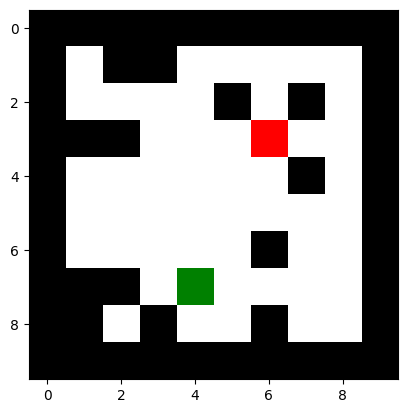

(8, 2, 5, 5)
(7, 5, 5)
(23, 5, 5)


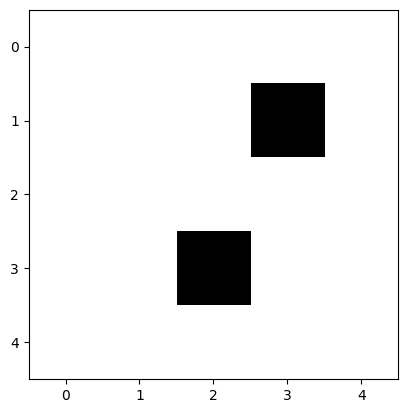

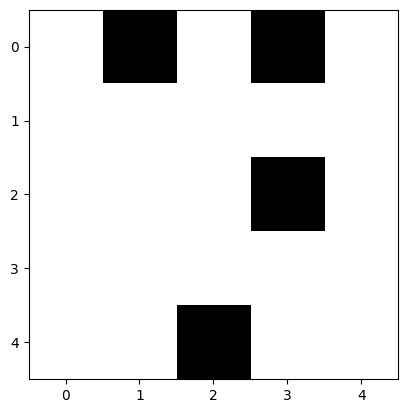

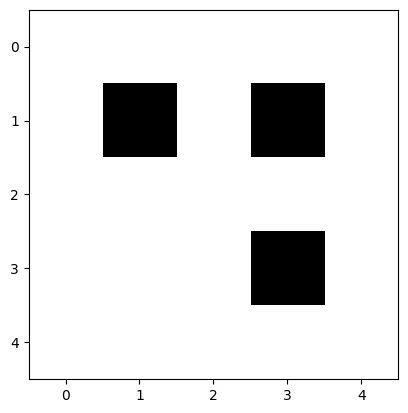

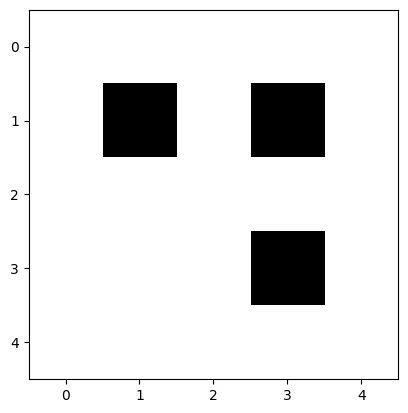

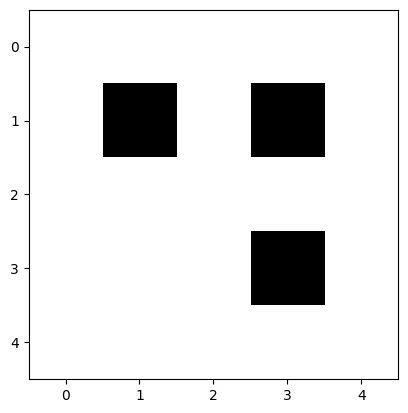

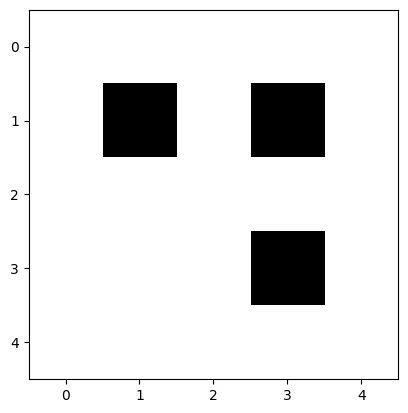

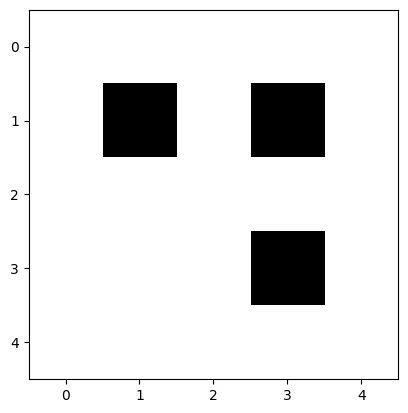

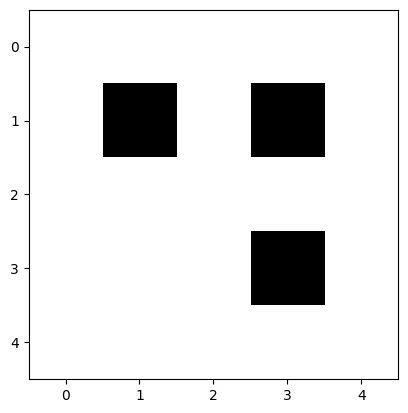

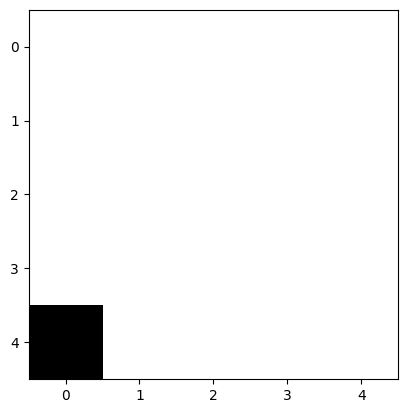

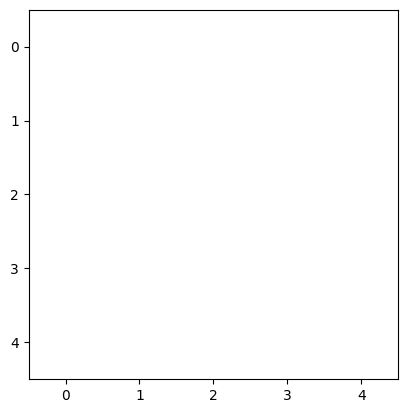

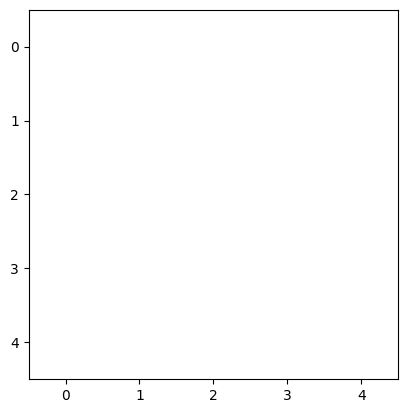

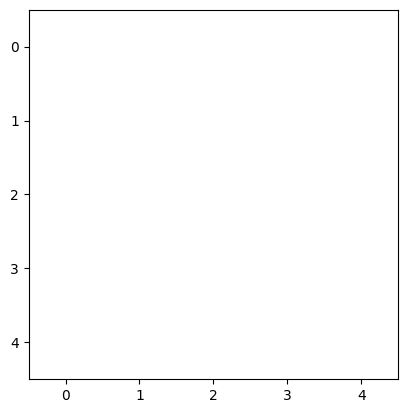

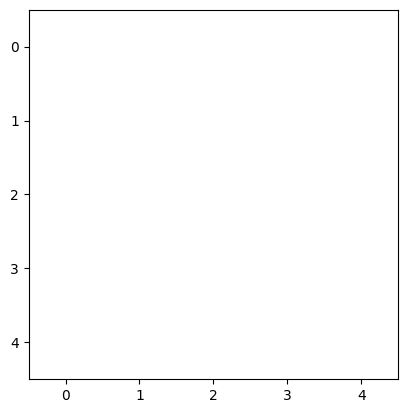

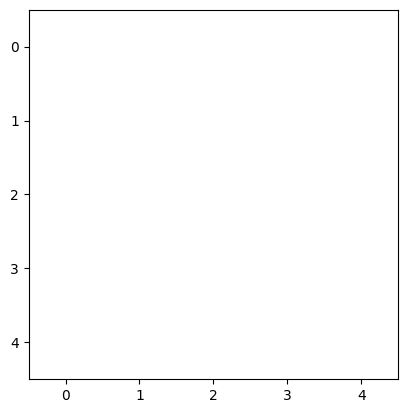

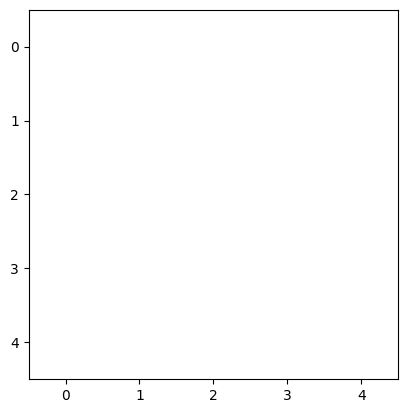

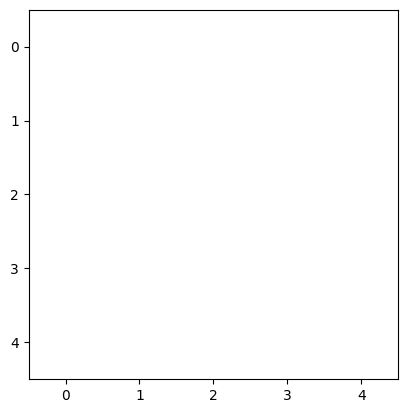

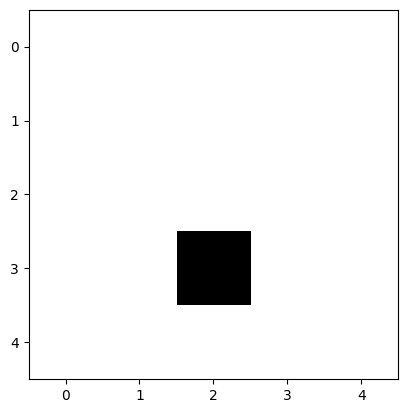

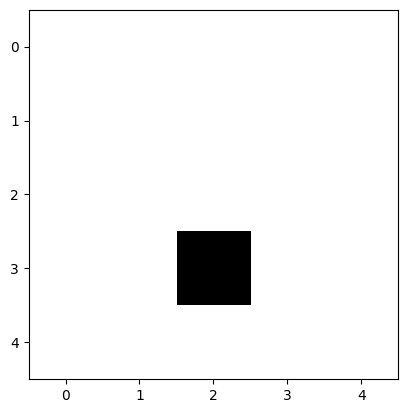

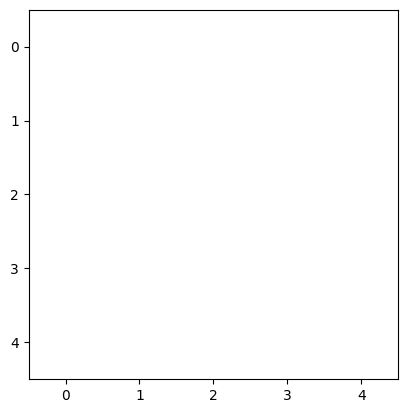

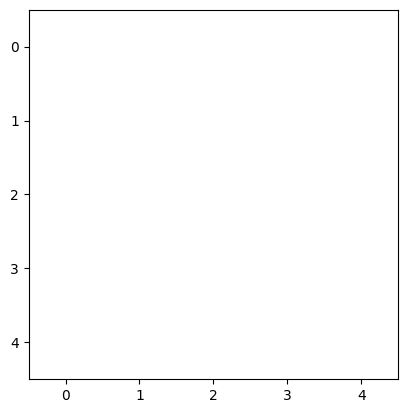

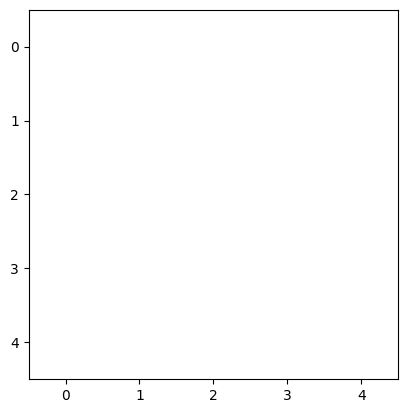

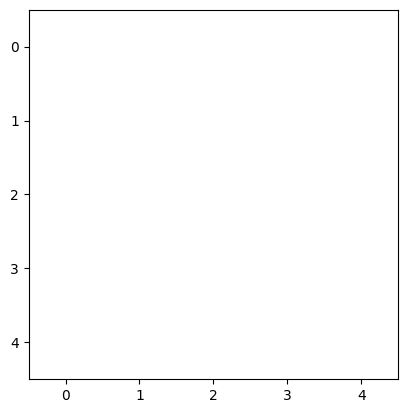

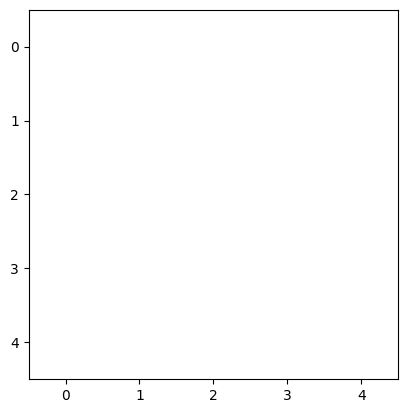

(26,)
[0.6   0.6   0.6   0.6   0.6   0.6   0.6   0.6   0.5   0.4   0.3   0.3
 0.3   0.3   0.3   0.3   0.857 0.929 1.    1.    1.    1.    1.    1.
 0.4   0.7  ]


In [7]:
# Test observation history
maze = Maze(10, 10, 0.3, seed=0)
state = maze.get_initial_state()
node = Node(state, maze)
maze.visualize_state()

# Checking the spatial features
# print(node.obs_history.shape)
# print(node.action_plane_history.shape)
# print(node.get_spatial_history().shape)
# print(node.get_spatial_history())

# # Checking the scalar features
# print(node.get_scalar_history().shape)
# print(node.get_scalar_history())

# Check the histories after taking some actions
actions = [0,0] # Down, Down
for action in actions:
    state = maze.get_next_state(state, action)
    node = Node(state, maze, parent=node, last_action=action)

# Checking the spatial features
print(node.obs_history.shape)
print(node.action_plane_history.shape)
print(node.get_spatial_history().shape)
for plane in node.get_spatial_history():
    maze.visualize_state(plane)

# Checking the scalar features
print(node.get_scalar_history().shape)
print(node.get_scalar_history())

In [8]:
class AlphaZero:
    def __init__(self, model: ResNet, optimizer, search_alg: AlphaMCTS, seed=None):
        self.model = model
        self.optimizer = optimizer
        self.search_alg = search_alg

        self.cfg = cfg.learn

        if seed is not None:
            np.random.seed(seed)
        
        self.last_success_rates = []
        self.last_maze_cfg = None
        self.original_maze_cfg = cfg.maze
    
    def get_maze_cfg_from_curriculum(self):
        if len(self.last_success_rates) < 3:
            # Not enough data yet, start with initial maze size
            maze_cfg = copy.deepcopy(self.original_maze_cfg)
            maze_cfg.width.max = 6
            maze_cfg.height.max = 6
            return maze_cfg

        if all(rate >= self.cfg.curriculum_success_threshold for rate in self.last_success_rates):
            # Increase the maze size
            maze_cfg = copy.deepcopy(self.last_maze_cfg)
            maze_cfg.width.max = min(self.last_maze_cfg.width.max + 2, self.original_maze_cfg.width.max)
            maze_cfg.height.max = min(self.last_maze_cfg.height.max + 2, self.original_maze_cfg.height.max)
        else:
            # Keep the maze size the same
            maze_cfg = self.last_maze_cfg
        
        return maze_cfg
    
    def self_play(self, maze_cfg):

        maze_params = Maze.generate_maze_params(self.cfg.num_parallel_games, maze_cfg=maze_cfg)
        episodes = [GameEpisode(Maze(*params)) for params in maze_params]
        ret_mem = []
        n_successes = 0
        optimal_path_ratio_sum = 0
        while len(episodes) > 0:
            
            self.search_alg.batch_search(episodes)

            # Serially process the episodes
            for i in range(len(episodes))[::-1]:
                ep = episodes[i]

                action_probs = np.zeros(ep.game.action_size)
                for child in ep.root.children:
                    action_probs[child.last_action] = child.visit_count
                action_probs /= np.sum(action_probs)
                ep.memory.append((ep.root.get_spatial_history(),
                                  ep.root.get_scalar_history(),
                                  action_probs))
                ep.reward_history.append(ep.root.state.reward)

                action = np.random.choice(ep.game.action_size, p=action_probs)
                for child in ep.root.children:
                    if child.last_action == action:
                        # Set the child as the new root to preserve the search tree
                        ep.root = child
                        break
                ep.state = ep.root.state

                final_reward, is_terminal = ep.game.get_value_and_terminated(ep.state)

                if is_terminal:
                    # Unroll the reward history and memory
                    for mem, reward_to_go in zip(ep.memory, ep.reward_history):
                        reward_to_go = final_reward - reward_to_go
                        ret_mem.append((*mem, ep.game.normalize_reward(reward_to_go)))
                    if (ep.state.x, ep.state.y) == ep.game.target:
                        n_successes += 1
                        optimal_path_ratio_sum += (len(ep.memory)+1)/len(ep.game.shortest_path)

                    del episodes[i]
        
        return ret_mem, n_successes, optimal_path_ratio_sum
        
    def train(self, memory, iteration, epoch):
        random.shuffle(memory)
        total_loss = 0.0

        for batchIdx in range(0, len(memory), self.cfg.train_batch_size):
            batch = memory[batchIdx:batchIdx + self.cfg.train_batch_size]
            obs, scalar_features, policy_targets, value_targets = zip(*batch)

            obs, scalar_features, policy_targets, value_targets = np.array(obs), np.array(scalar_features), np.array(policy_targets), np.array(value_targets).reshape(-1, 1)
            obs = torch.tensor(obs, dtype=torch.float32, device=self.model.device)
            scalar_features = torch.tensor(scalar_features, dtype=torch.float32, device=self.model.device)
            policy_targets = torch.tensor(policy_targets, dtype=torch.float32, device=self.model.device)
            value_targets = torch.tensor(value_targets, dtype=torch.float32, device=self.model.device)
            
            policy_pred, value_pred = self.model(obs, scalar_features)
            value_loss = F.mse_loss(value_pred, value_targets)
            policy_loss = F.cross_entropy(policy_pred, policy_targets)
            loss = value_loss + policy_loss

            total_loss += loss.item()
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            if self.cfg.use_wandb:
                # Log metrics for the current batch
                wandb.log({"batch_loss": loss.item()})
        
        avg_loss = total_loss / (len(memory) // self.cfg.train_batch_size)
        if self.cfg.use_wandb:
            # Log average loss for the epoch
            wandb.log({"train_epoch_loss": avg_loss, "iteration": iteration, "epoch": epoch})


    def learn(self):
        if self.cfg.use_wandb:
            wandb.init(project="alpha-zero-discrete-maze",
                name=cfg.name,
                config=OmegaConf.to_container(cfg, resolve=True, throw_on_missing=True),
                save_code=True)
            
            wandb.watch(self.model, log="all", log_freq=10)  # Log model gradients and parameters
        
        start_time = time.time()

        for iteration in range(self.cfg.num_learn_iters):
            memory = []
            successes = 0
            optimal_path_ratio_sum = 0
        
            self.model.eval()

            # Initialize all games and an episode for each game
            if self.cfg.use_curriculum:
                maze_cfg = self.get_maze_cfg_from_curriculum()
                wandb.log({"max_maze_width": maze_cfg.width.max})
                self.last_maze_cfg = maze_cfg
            else:
                maze_cfg = cfg.maze

            # Calculate the number of batches
            n_batches = self.cfg.num_self_play_iters // self.cfg.num_parallel_games


            for _ in trange(n_batches):
                batch_episode_mems, num_episode_successes, opt_path_ratio_sum = self.self_play(maze_cfg)
                successes += num_episode_successes
                optimal_path_ratio_sum += opt_path_ratio_sum
                memory += batch_episode_mems

            success_rate = successes / self.cfg.num_self_play_iters
            optimal_path_ratio = optimal_path_ratio_sum / successes
            self.last_success_rates.append(success_rate)
            if len(self.last_success_rates) > 3:
                self.last_success_rates.pop(0)  # Keep only the last 3 success rates
            if self.cfg.use_wandb:
                # Log the success rate for self-play games
                wandb.log({"success_rate": success_rate, "optimal_path_ratio": optimal_path_ratio, "iteration": iteration, "wall_time": time.time() - start_time})
                
            self.model.train()
            for epoch in trange(self.cfg.num_train_epochs):
                self.train(memory, iteration, epoch)
            
            # Save if iter divides save_every or if it is the last iteration
            if (iteration % self.cfg.save_every == 0 and iteration != 0) or iteration == self.cfg.num_learn_iters - 1:
                torch.save(self.model.state_dict(), f"checkpoints/{cfg.name}_model_{iteration}.pt")
                torch.save(self.optimizer.state_dict(), f"checkpoints/{cfg.name}_optimizer_{iteration}.pt")

                if self.cfg.use_wandb:
                    # Log model checkpoint to W&B
                    wandb.save(f"{cfg.name}_model_{iteration}.pt")
                    wandb.save(f"{cfg.name}_optimizer_{iteration}.pt")
        if self.cfg.use_wandb:
            wandb.finish()
            


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ResNet(cfg.model, device)
if "load_checkpoint" in cfg.learn:
    # Replace "optimizer" with "model"
    model_filename = cfg.learn.load_checkpoint.replace("optimizer", "model")
    model.load_state_dict(torch.load(f"checkpoints/{model_filename}.pt"))

optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learn.lr, weight_decay=cfg.learn.weight_decay)
if "load_checkpoint" in cfg.learn:
    # Replace "model" with "optimizer"
    model_filename = cfg.learn.load_checkpoint.replace("model", "optimizer")
    optimizer.load_state_dict(torch.load(f"checkpoints/{model_filename}.pt"))

mcts = AlphaMCTS(search_cfg=cfg.search, model=model)

alphaZero = AlphaZero(model, optimizer, mcts, seed=0)
alphaZero.learn()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: shaoyuan (contact_placement). Use `wandb login --relogin` to force relogin


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

batch_loss,▅▆▄▃▆▄█▄█▅▄▄▂▅▂▂▃▆▃▄▆▂▅▆▅▅▃▄▃▃▂▁▃▃▃▄▃▄▂▁
epoch,▆▁▆▆█▆█▁██▁██▁▃▃▃▃▆▃▁▆▃███▁▁▁▁▃█▁▆█▆▁▃▃▁
iteration,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
max_maze_width,▁▁▁▁▁▂▂▃▄▄▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█████████████
optimal_path_ratio,▅▃▅▁▃▃▄▆▆▅▅▅▄▅▆▆▆▅▄▄▄▅▄▄▅▄▆▄▆▆▅█▆▆█▆▆▆▇▇
success_rate,▇█▆▅▃▆▅▅▅▄▆▄▃▅▄▄▆▄▂▅▅▄▅▄▃▄▃▃▂▁▂▃▂▃▄▁▂▂▃▆
train_epoch_loss,▂█▇█▄▄▆▆▃▃▂▁▄▂▂▃▁▁▁▄▂▂▅▃▂▃▃▄▂▁▄▂▂▂▂▁▄▃▂▁
wall_time,▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▅▅▆▆▆▆▆▇▇▇▇███
batch_loss,0.26363
epoch,3
iteration,99


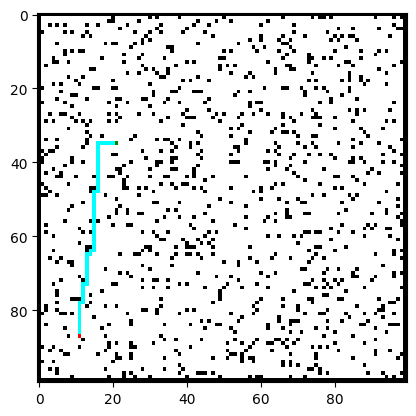

/tmp/ipykernel_469843/2221726946.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"checkpoints/{cfg.name}_model_{cfg.learn.num_learn_it

TypeError: AlphaMCTS.query_model() got an unexpected keyword argument 'game'

In [10]:
# params = Maze.generate_maze_params(1, cfg)

params = np.array([[100, 100, 0.1]])
width, height, cell_occupancy_prob = params[0]
width, height = int(width), int(height)
maze = Maze(*params[0])

maze.visualize_path()

model = ResNet(cfg.model, device)
model.load_state_dict(torch.load(f"checkpoints/{cfg.name}_model_{cfg.learn.num_learn_iters - 1}.pt"))
# model.load_state_dict(torch.load(f"checkpoints/{cfg.name}_model_{100}.pt"))
# model.load_state_dict(torch.load(f"checkpoints/maze_4x4_binaryreward_maxsteps2_wstepsleft_round3_model_13.pt"))
model.eval()

new_cfg = copy.deepcopy(cfg)
new_cfg.search.num_simulations = 50
mcts = AlphaMCTS(search_cfg=new_cfg.search, model=model)

_ = mcts.play_game(game=maze, verbose=True)

In [ ]:
# Positions around target:
positions = [(maze.target[0] + dx, maze.target[1] + dy) for dx in [-1, 0, 1] for dy in [-1, 0, 1]]
print(f"Target: {maze.target}")
for pos in positions:
    if pos == maze.target or maze.map[pos] == 1:
        continue
    state = Maze.State(*pos, 1, 0)
    policy, final_reward = mcts.query_model(state, game=maze)
    print(f"Position: {pos}, policy: {policy}, policy argmax:{maze.action_to_string(np.argmax(policy))} policy value: {final_reward}")
    search_probs = mcts.search(game=maze, state=state)
    print(f"search: {search_probs}, search argmax: {maze.action_to_string(np.argmax(search_probs))}")
# Actions: Down, Up, Left, Right